In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview and Demo

In [ ]:
directory = '/content/drive/MyDrive/DATASET/COVID-19_Radiography_Dataset/COVID'
images_path = glob(directory + '/images/*.png')
masks_path = glob(directory + '/masks/*.png')

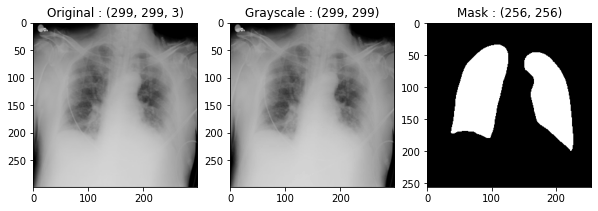

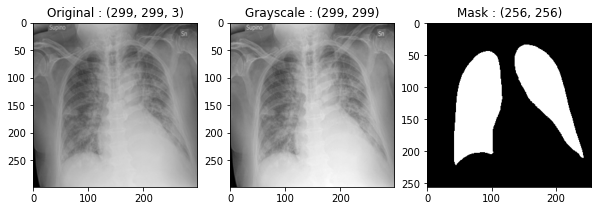

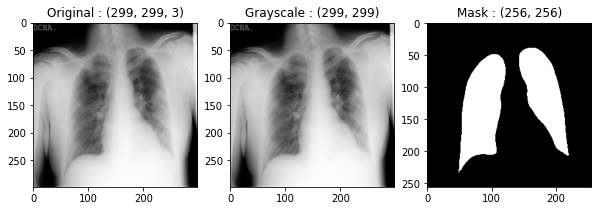

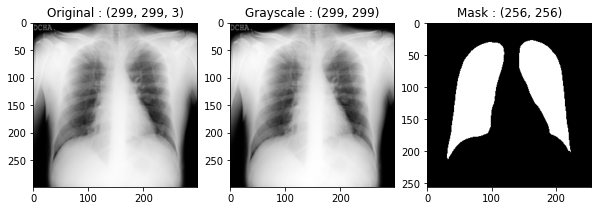

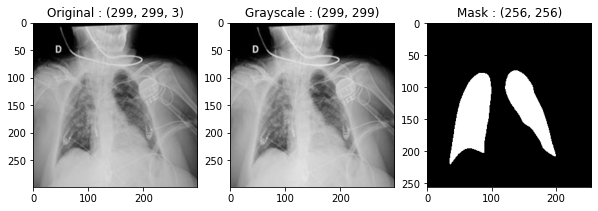

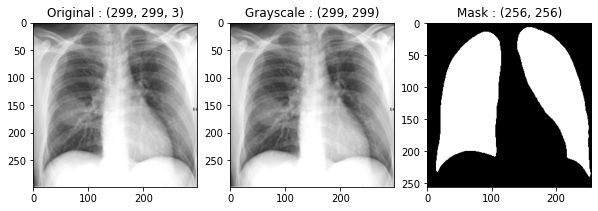

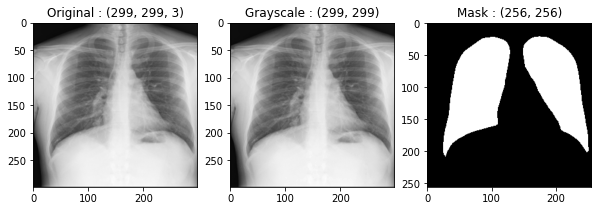

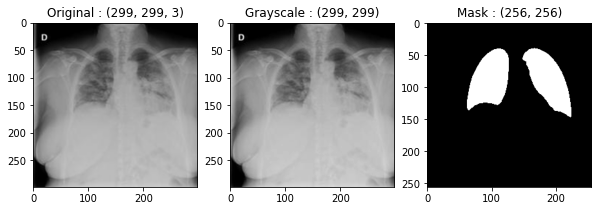

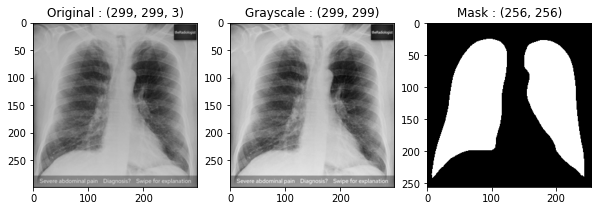

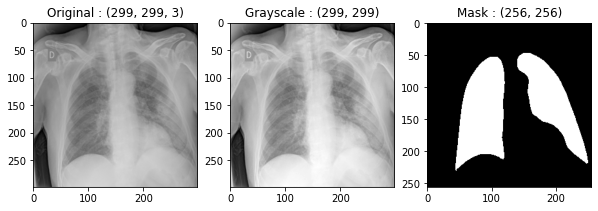

In [ ]:
for index in range(10):
    image_path = images_path[index]
    mask_path = masks_path[index]

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axs[0].imshow(image)
    axs[0].set_title(f'Original : {image.shape}')
    axs[1].imshow(gray_image, cmap='gray')
    axs[1].set_title(f'Grayscale : {gray_image.shape}')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title(f'Mask : {mask.shape}')
    plt.show()

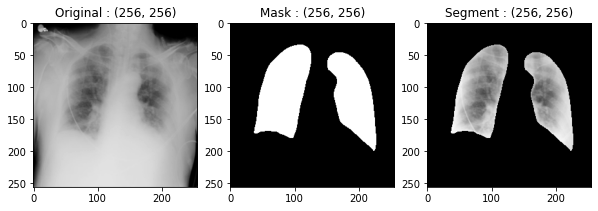

In [ ]:
index = 0
image_path = images_path[index]
mask_path = masks_path[index]

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, (256, 256))

segment = cv2.bitwise_and(image, image, mask=mask)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[0].set_title(f'Original : {image.shape}')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title(f'Mask : {mask.shape}')
axs[2].imshow(segment, cmap='gray')
axs[2].set_title(f'Segment : {segment.shape}')
plt.show()

In [ ]:
index = 0
image_path = images_path[index]

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(image)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[0].set_title(f'Original : {image.shape}')
axs[1].imshow(cl1, cmap='gray')
axs[1].set_title(f'CLAHE : {mask.shape}')
plt.show()

# Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras

##Tensorflow Dataset

In [ ]:
directory = '/content/drive/MyDrive/DATASET/COVID-19_Radiography_Dataset/COVID'
images_path = sorted(glob(directory + '/images/*.png'))
masks_path = sorted(glob(directory + '/masks/*.png'))

In [ ]:
len(images_path), len(masks_path)

(3616, 3616)

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images_path, masks_path, test_size=0.1, random_state=123)

In [ ]:
len(train_images), len(test_images)

(3254, 362)

In [ ]:
img_size = 256
def CLAHEprocess(image):   
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl_image = clahe.apply(image)
    
    return cl_image

def map_tensor(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)
    
    image = tf.io.decode_png(image, channels=1, dtype=tf.uint8)
    mask = tf.io.decode_png(mask, channels=1, dtype=tf.uint8)

    image = tf.image.resize(image, [img_size, img_size])
    mask = tf.image.resize(mask, [img_size, img_size])

    image = tf.cast(image, tf.uint8)
    image = tf.squeeze(image, axis=2)

    # image = tf.numpy_function(CLAHEprocess, [image], tf.uint8)

    image = tf.expand_dims(image, axis=2)

    image = tf.cast(image, tf.float32)/255.0
    mask = tf.cast(mask, tf.uint8)/255
    
    return image, mask

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=123):
        super().__init__()
        self.augment_image = keras.Sequential(
            [
             tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=seed),
             tf.keras.layers.experimental.preprocessing.RandomRotation(0.05, fill_mode="nearest", seed=seed)
             ]
        )
        self.augment_mask = keras.Sequential(
            [
             tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=seed),
             tf.keras.layers.experimental.preprocessing.RandomRotation(0.05, fill_mode="nearest", seed=seed)
             ]
        )
        
    def call(self, image, mask):
        image = self.augment_image(image)
        mask = self.augment_mask(mask)
        return image, mask

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_ds = (
    train_ds
    .map(map_tensor, AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(Augment())
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_ds = (
    test_ds
    .map(map_tensor, AUTOTUNE)
    .batch(BATCH_SIZE)
)

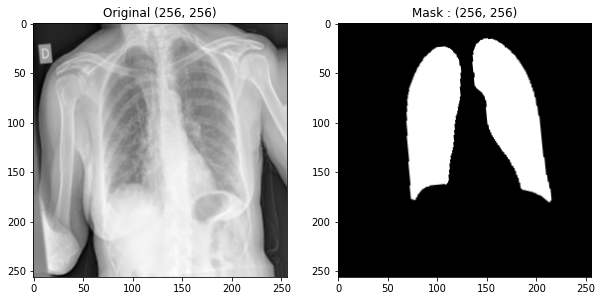

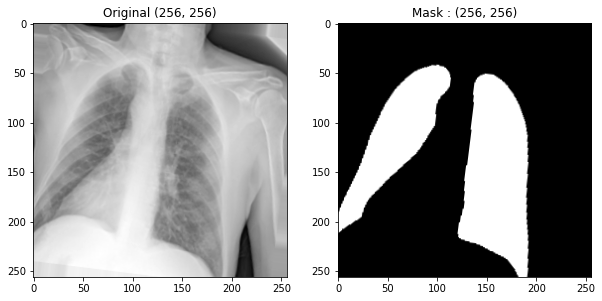

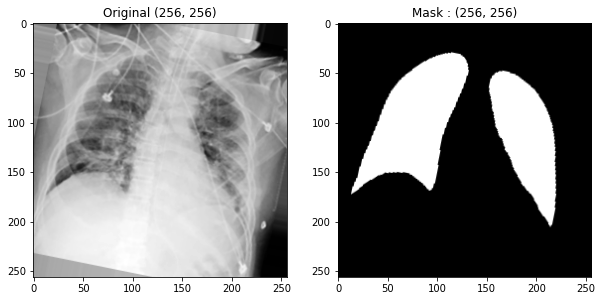

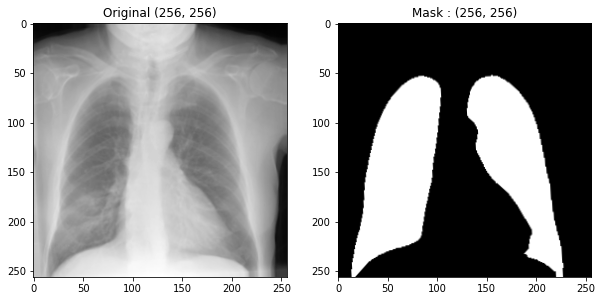

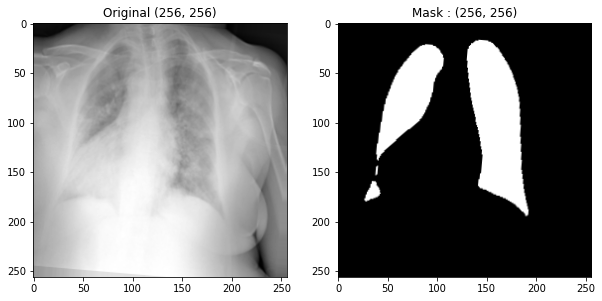

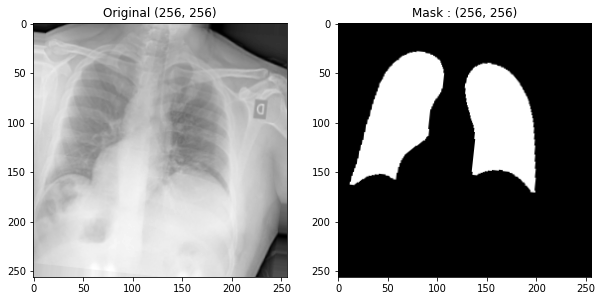

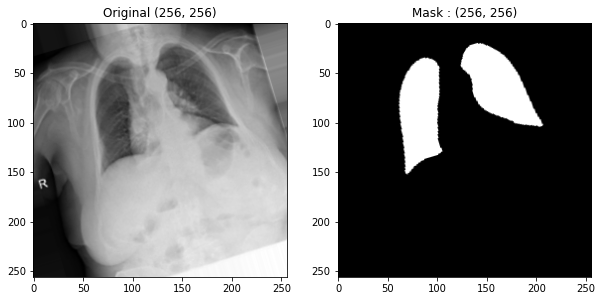

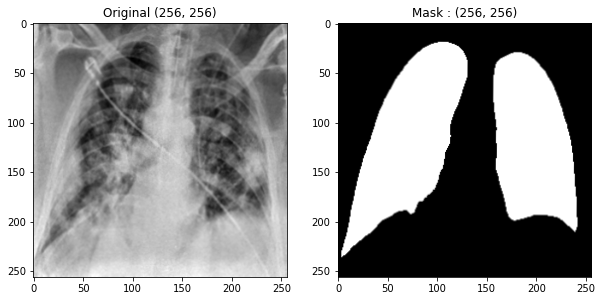

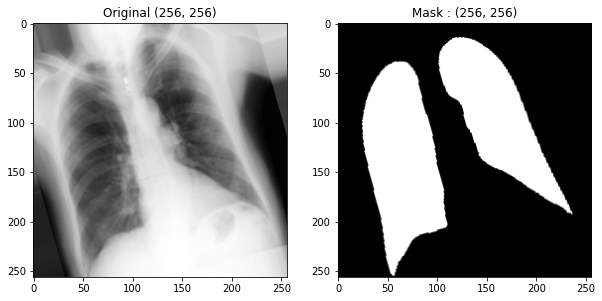

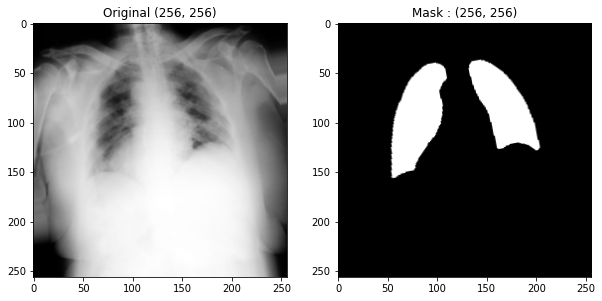

In [ ]:
for images, masks in train_ds.take(1):
  for index in range(10):
    image = images[index]
    mask = masks[index]

    image = np.reshape(image, (img_size, img_size))
    mask = np.reshape(mask, (img_size, img_size))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title(f'Original {image.shape}')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title(f'Mask : {mask.shape}')
    plt.show()
  break

##Model

In [ ]:
def unet(input_size=(256, 256, 1)):
  inputs = keras.layers.Input(shape=input_size)

  # 256 * 256 -> 128 * 128
  conv1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
  conv1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
  pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  # 128 * 128 -> 64 * 64
  conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
  conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
  pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  # 64 * 64 -> 32 * 32
  conv3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
  conv3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
  pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  # 32 * 32 -> 16 * 16
  conv4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
  conv4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
  pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  # 16 * 16 -> 8 * 8
  conv5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool4)
  conv5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv5)
  pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)

  conv6 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
  conv6 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6) 
  # 8 * 8 -> 16 * 16
  convT5 = keras.layers.Conv2DTranspose(512, 3, strides=(2, 2), padding='same')(conv6)
  concat5 = keras.layers.Concatenate()([convT5, conv5])
  up5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(concat5)
  up5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up5)
  # 16 * 16 -> 32 * 32
  convT4 = keras.layers.Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(up5)
  concat4 = keras.layers.Concatenate()([convT4, conv4])
  up4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat4)
  up4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up4)
  # 32 * 32 -> 64 * 64
  convT3 = keras.layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(up4)
  concat3 = keras.layers.Concatenate()([convT3, conv3])
  up3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat3)
  up3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up3)
  # 64 * 64 -> 128 * 128
  convT2 = keras.layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(up3)
  concat2 = keras.layers.Concatenate()([convT2, conv2])
  up2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)
  up2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
  # 128 * 128 -> 256 * 256
  convT1 = keras.layers.Conv2DTranspose(32, 3, strides=(2, 2), padding='same')(up2)
  concat1 = keras.layers.Concatenate()([convT1, conv1])
  up1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(concat1)
  up1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(up1)

  outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up1)

  return keras.Model(inputs=inputs, outputs=outputs)                   

In [ ]:
def dice_coeff(y_true, y_pred):
  y_true_f = tf.squeeze(y_true)
  y_pred_f = tf.squeeze(y_pred)
  intersection = tf.math.reduce_sum(y_true_f*y_pred_f)
  score = (2. * intersection + 1) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + 1)

  return score

def dice_loss(y_true, y_pred):
  return 1 - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
  loss = 0.5*keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
  return loss

In [ ]:
model = unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/lungsegment.hdf5',
    monitor='val_dice_coeff',
    save_weights_only=True
)

model.compile(
    loss=bce_dice_loss,
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=['accuracy', dice_coeff]
)

In [ ]:
history = model.fit(train_ds, epochs=50,
                    validation_data=test_ds,
                    callbacks=[checkpoint_callback])

Epoch 1/50
51/51 [==============================] - 75s 1s/step - loss: 0.4861 - accuracy: 0.8056 - dice_coeff: 0.4550 - val_loss: 0.3759 - val_accuracy: 0.8764 - val_dice_coeff: 0.5611
Epoch 2/50
51/51 [==============================] - 78s 2s/step - loss: 0.2871 - accuracy: 0.8814 - dice_coeff: 0.7014 - val_loss: 0.2530 - val_accuracy: 0.8937 - val_dice_coeff: 0.7678
Epoch 3/50
51/51 [==============================] - 79s 2s/step - loss: 0.2148 - accuracy: 0.9100 - dice_coeff: 0.7834 - val_loss: 0.1774 - val_accuracy: 0.9344 - val_dice_coeff: 0.8154
Epoch 4/50
51/51 [==============================] - 79s 2s/step - loss: 0.1481 - accuracy: 0.9355 - dice_coeff: 0.8524 - val_loss: 0.1421 - val_accuracy: 0.9411 - val_dice_coeff: 0.8673
Epoch 5/50
51/51 [==============================] - 80s 2s/step - loss: 0.1106 - accuracy: 0.9496 - dice_coeff: 0.8917 - val_loss: 0.0946 - val_accuracy: 0.9641 - val_dice_coeff: 0.9072
Epoch 6/50
51/51 [==============================] - 79s 2s/step - loss

##Predicted on Test set and Other Dataset

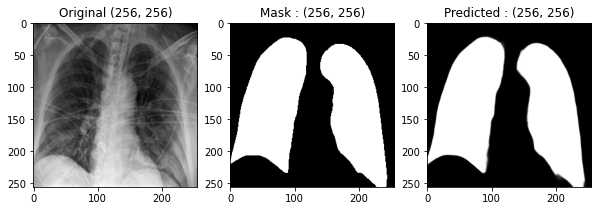

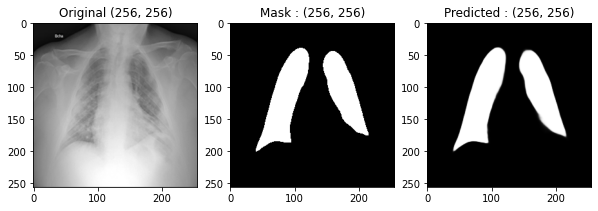

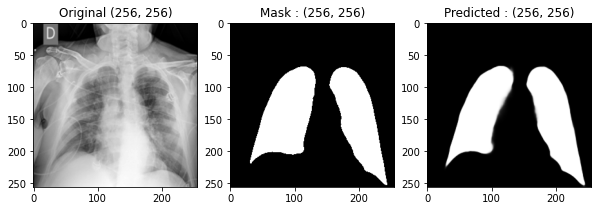

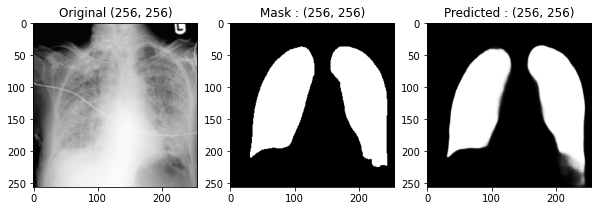

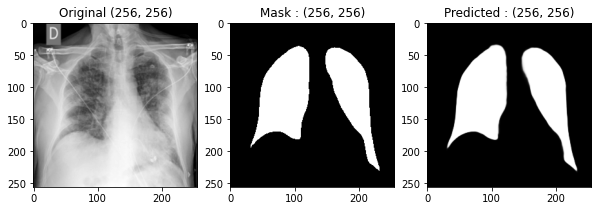

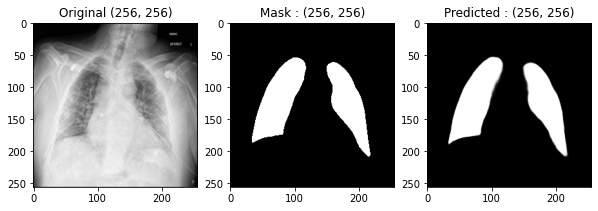

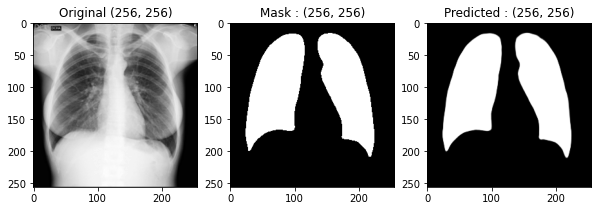

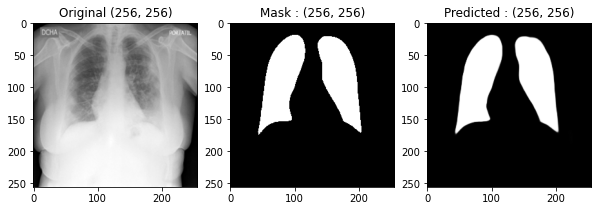

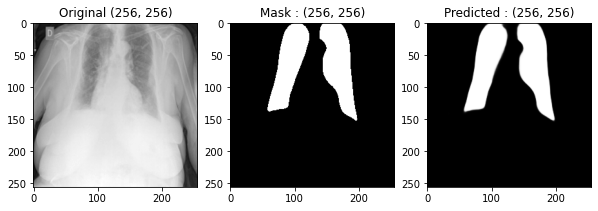

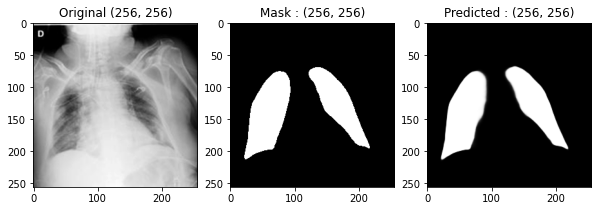

In [ ]:
model = unet()

model.compile(
    loss=bce_dice_loss,
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=['accuracy', dice_coeff]
)

model.load_weights('/content/drive/MyDrive/lungsegment.hdf5')

for images, masks in test_ds.take(1):
  predict_masks = model.predict(images)
  for index in range(10):
    image = images[index]
    mask = masks[index]
    predict = predict_masks[index]

    image = np.reshape(image, (img_size, img_size))
    mask = np.reshape(mask, (img_size, img_size))
    predict = np.reshape(predict, (img_size, img_size))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title(f'Original {image.shape}')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title(f'Mask : {mask.shape}')
    axs[2].imshow(predict, cmap='gray')
    axs[2].set_title(f'Predicted : {predict.shape}')
    plt.show()
  break

##Other Datasets

In [ ]:
directory = '/content/drive/MyDrive/DATASET/COVID-19_Radiography_Dataset/Lung_Opacity'
other_images_path = sorted(glob(directory + '/images/*.png'))
other_masks_path = sorted(glob(directory + '/masks/*.png'))

In [ ]:
orther_ds = tf.data.Dataset.from_tensor_slices((other_images_path, other_masks_path))
orther_ds = (
    orther_ds
    .map(map_tensor, AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [ ]:
model = unet()

model.compile(
    loss=bce_dice_loss,
    optimizer=keras.optimizers.Adam(5e-4),
    metrics=['accuracy', dice_coeff]
)

model.load_weights('/content/drive/MyDrive/lungsegment.hdf5')

model.evaluate(orther_ds)

94/94 [==============================] - 1448s 15s/step - loss: 0.0361 - accuracy: 0.9870 - dice_coeff: 0.9640


[0.03610111400485039, 0.9870098829269409, 0.963981568813324]

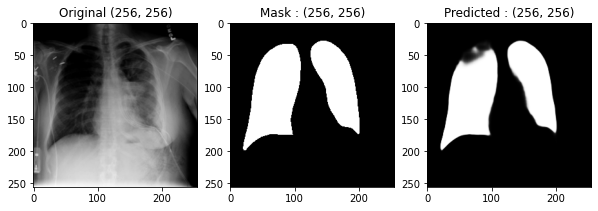

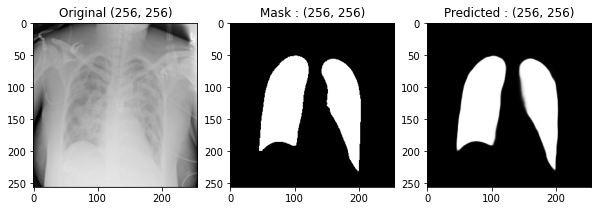

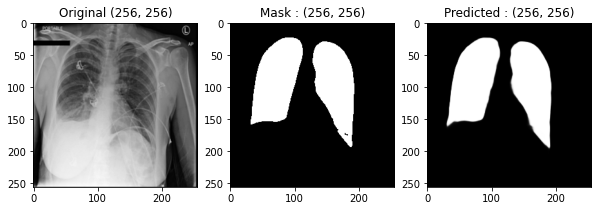

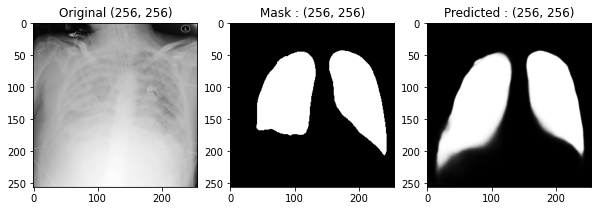

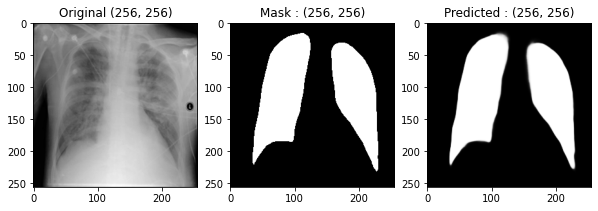

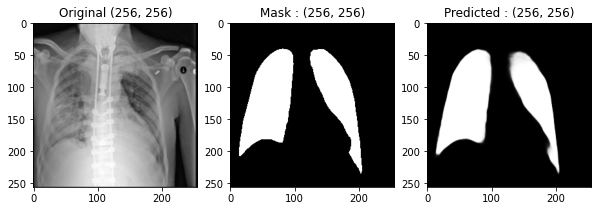

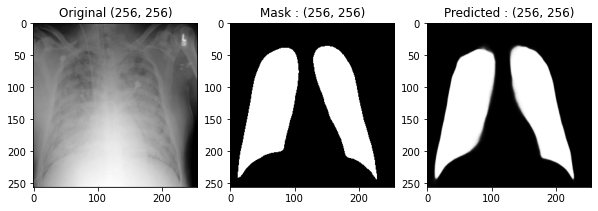

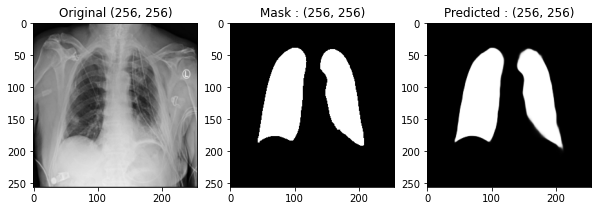

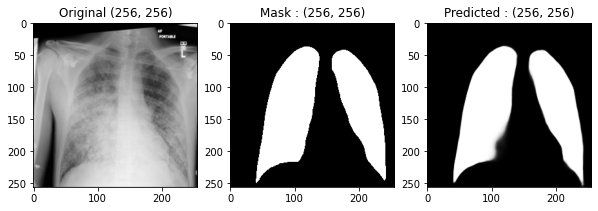

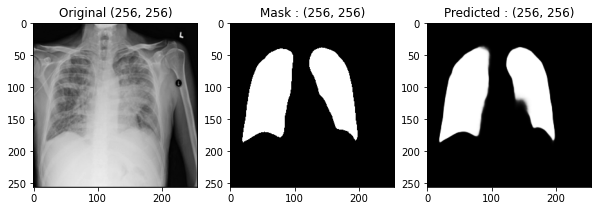

In [ ]:
for images, masks in orther_ds.take(1):
  predict_masks = model.predict(images)
  for index in range(10):
    image = images[index]
    mask = masks[index]
    predict = predict_masks[index]

    image = np.reshape(image, (img_size, img_size))
    mask = np.reshape(mask, (img_size, img_size))
    predict = np.reshape(predict, (img_size, img_size))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title(f'Original {image.shape}')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title(f'Mask : {mask.shape}')
    axs[2].imshow(predict, cmap='gray')
    axs[2].set_title(f'Predicted : {predict.shape}')
    plt.show()
  break